## Exercise 3.3

What would the Italian regions look like if the territorial division were
done using a Voronoi tessellation based on the position of the
regional capitals? What about provinces?
* Download the positions of Italian cities (comuni)
* Use the geovoronoi package to compute Voronoi shapes
* Plot the tessellation with folium
* Submit a (well commented) python notebook

## Installing the packages

In [ ]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 305 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 8.2 MB/s 
     |███████████████

## Importing Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

#to tessellate and plot tessellations
from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf

#for the Voronoi Tessellation
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import *

#to download and extract the shape files
import urllib.request
import zipfile
import os

## Downloading the file with the Italian Administrative subdivisions

In [ ]:
file_name = 'gadm41_ITA_shp.zip'

#downloading a shp with the italian regions
urllib.request.urlretrieve('https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_ITA_shp.zip', file_name)

#extracting the zipped files
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()
#removing the zip
os.remove(file_name)

#getting the shp files from the directory
shape_files = [x for x in os.listdir() if x[-3:] == 'shp']
print(shape_files)

['gadm41_ITA_0.shp', 'gadm41_ITA_2.shp', 'gadm41_ITA_3.shp', 'gadm41_ITA_1.shp']


In [ ]:
#after a rapid check I divided the shape files for each administrative subdivision
italy = gpd.read_file('gadm41_ITA_0.shp', crs='epsg:4326')
regions = gpd.read_file('gadm41_ITA_1.shp', crs='epsg:4326')
provinces = gpd.read_file('gadm41_ITA_2.shp', crs='epsg:4326')
municipalities = gpd.read_file('gadm41_ITA_3.shp', crs='epsg:4326')

In [ ]:
#getting the centroid of italy as the map starting location
italy_center = italy['geometry'][0].centroid.coords[0]

## Doing some checks

In [ ]:
#checking if the geometries are plotted correctly and the centroid are realistic
pisa = municipalities[municipalities['NAME_3'] == 'Pisa']

def flip_xy(point):
    return point.y, point.x #I'm tired of flipping them manually when using raw coordinates on folium

italy_map = folium.Map(location=flip_xy(pisa.centroid), zoom_start=12)
folium.GeoJson(pisa.to_json()).add_to(italy_map)
folium.GeoJson(pisa.centroid.to_json()).add_to(italy_map)
italy_map

## Getting the centroids instead of the polygons

In [ ]:
#substituting the municipalities polygons with their centroid
municipalities['geometry'] = municipalities.centroid
municipalities.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,ITA.1.1.1_1,ITA,Italy,ITA.1_1,Abruzzo,NA,ITA.1.1_1,Chieti,NA,Altino,NA,NA,Commune,Commune,NA,IT.CH.AL,POINT (14.35036 42.10723)
1,ITA.1.1.2_1,ITA,Italy,ITA.1_1,Abruzzo,NA,ITA.1.1_1,Chieti,NA,Archi,NA,NA,Commune,Commune,NA,IT.CH.AC,POINT (14.38600 42.08229)
2,ITA.1.1.3_1,ITA,Italy,ITA.1_1,Abruzzo,NA,ITA.1.1_1,Chieti,NA,Ari,NA,NA,Commune,Commune,NA,IT.CH.AR,POINT (14.25707 42.28728)
3,ITA.1.1.4_1,ITA,Italy,ITA.1_1,Abruzzo,NA,ITA.1.1_1,Chieti,NA,Arielli,NA,NA,Commune,Commune,NA,IT.CH.AE,POINT (14.30187 42.25769)
4,ITA.1.1.5_1,ITA,Italy,ITA.1_1,Abruzzo,NA,ITA.1.1_1,Chieti,NA,Atessa,NA,NA,Commune,Commune,NA,IT.CH.AT,POINT (14.46221 42.08922)


In [ ]:
#storing the name of the provinces and region capitals
provinces_names = municipalities['NAME_2'].unique()
capitals_names = ["L' Aquila", 'Bari', 'Potenza', 'Reggio Di Calabria', 'Napoli', 'Bologna', 'Trieste', 'Roma', 'Genova', 'Milano', 
                  'Ancona', 'Campobasso', 'Torino', 'Cagliari', 'Palermo', 'Firenze', 'Trento', 'Perugia', 'Aosta', 'Venezia']

In [ ]:
#selecting the element of the dataframes in the previous lists
province_cap = municipalities[municipalities['NAME_3'].isin(provinces_names)].reset_index(drop=True) #resetting index to avoid error in loops
region_cap = municipalities[municipalities['NAME_3'].isin(capitals_names)].reset_index(drop=True) #resetting index to avoid error in loops

In [ ]:
region_cap

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,ITA.1.2.49_1,ITA,Italy,ITA.1_1,Abruzzo,NA,ITA.1.2_1,L'Aquila,NA,L' Aquila,NA,NA,Commune,Commune,NA,IT.AQ.LA,POINT (13.42548 42.39404)
1,ITA.2.1.5_1,ITA,Italy,ITA.2_1,Apulia,NA,ITA.2.1_1,Bari,NA,Bari,NA,NA,Commune,Commune,NA,IT.BB.BI,POINT (16.84547 41.10345)
2,ITA.3.2.64_1,ITA,Italy,ITA.3_1,Basilicata,NA,ITA.3.2_1,Potenza,NA,Potenza,NA,NA,Commune,Commune,NA,IT.PZ.PO,POINT (15.80742 40.66055)
3,ITA.4.4.62_1,ITA,Italy,ITA.4_1,Calabria,NA,ITA.4.4_1,Reggio Di Calabria,NA,Reggio Di Calabria,NA,NA,Commune,Commune,NA,IT.RC.RC,POINT (15.71844 38.11376)
4,ITA.5.4.51_1,ITA,Italy,ITA.5_1,Campania,NA,ITA.5.4_1,Napoli,NA,Napoli,NA,NA,Commune,Commune,NA,IT.NA.NA,POINT (14.24072 40.85686)
5,ITA.6.1.6_1,ITA,Italy,ITA.6_1,Emilia-Romagna,NA,ITA.6.1_1,Bologna,NA,Bologna,NA,NA,Commune,Commune,NA,IT.BO.BO,POINT (11.33349 44.49828)
6,ITA.7.3.6_1,ITA,Italy,ITA.7_1,Friuli-Venezia Giulia,NA,ITA.7.3_1,Trieste,NA,Trieste,NA,NA,Commune,Commune,NA,IT.TS.TR,POINT (13.80653 45.66591)
7,ITA.8.4.97_1,ITA,Italy,ITA.8_1,Lazio,NA,ITA.8.4_1,Roma,NA,Roma,NA,NA,Commune,Commune,NA,IT.RM.RM,POINT (12.46300 41.88444)
8,ITA.9.1.25_1,ITA,Italy,ITA.9_1,Liguria,NA,ITA.9.1_1,Genova,NA,Genova,NA,NA,Commune,Commune,NA,IT.GE.GE,POINT (8.89291 44.44190)
9,ITA.10.8.72_1,ITA,Italy,ITA.10_1,Lombardia,NA,ITA.10.8_1,Milano,NA,Milano,NA,NA,Commune,Commune,NA,IT.MA.MI,POINT (9.17451 45.46921)


## Adapting the class to compute and plot the Voronoi I wrote previously
I had to fix something like the fact there were extra territories outside of italy in the output.</br>
Thus, even though those territories would be assigned to some italian provinces (funnily enough there were disputes about irredentist claims with all of them at some point in history) I removed them by doing an overlay so that only the parts of the geometries appearing in the voronoi and on italy would be plotted

In [ ]:
#get the convex hull from the squared tessellation to create the border of the space
def get_convex_hull(tess):
    polygon = tess.at[0, 'geometry']
    for tile in tess['geometry']:
        polygon = polygon.union(tile)
    return polygon.convex_hull

#creating the GeoDataFrame with the geometry of the tessellation
def to_GeoDataFrame(region_polys):
    tile_id=[]
    for i in range(len(region_polys)):
        tile_id.append(i)
    gdf = gpd.GeoDataFrame(columns=['tile_ID','geometry'], crs='epsg:4326')
    gdf['tile_ID'] = tile_id
    for index, row in gdf.iterrows():
        gdf.at[index, 'geometry'] = region_polys[index]
    return gdf

class Voronoi_Italy():
    #setting the constructor which takes the points as input
    def __init__(self, geoDataFrame, border_precision=50000): #obviouslt at the country level I need less precision
        self.geoDataFrame = geoDataFrame
        ### Getting the squared tessellation
        basic_tessellation = tiler.get('squared', base_shape=italy, meters=border_precision) #get basic tessellation of the borders of the italy
        poly_ch = get_convex_hull(basic_tessellation) #get the convex hull

        #getting the coordinates of the points of the GSM cells
        geom = self.geoDataFrame['geometry']
        coords = np.array(list(zip(geom.x, geom.y)))

        #performing the Voronoi tessellation
        vor = Voronoi(coords, qhull_options='Qbb Qc Qx')
        region_polys, region_pts = voronoi_regions_from_coords(geom, poly_ch)
        irredentist_voronoi = to_GeoDataFrame(region_polys)
        self.tess_voronoi = gpd.overlay(irredentist_voronoi, italy) #greatest change

    #adding a method to directly plot the result as before
    def plot(self):
        voronoi_map = plot_gdf(self.tess_voronoi, zoom=6)
        return plot_gdf(self.geoDataFrame, map_f=voronoi_map)

## Plotting the solutions

In [ ]:
Voronoi_Italy(region_cap).plot()

Results as before in an image to avoid storing the geometries on the notebook (it cannot be uploaded otherwise)

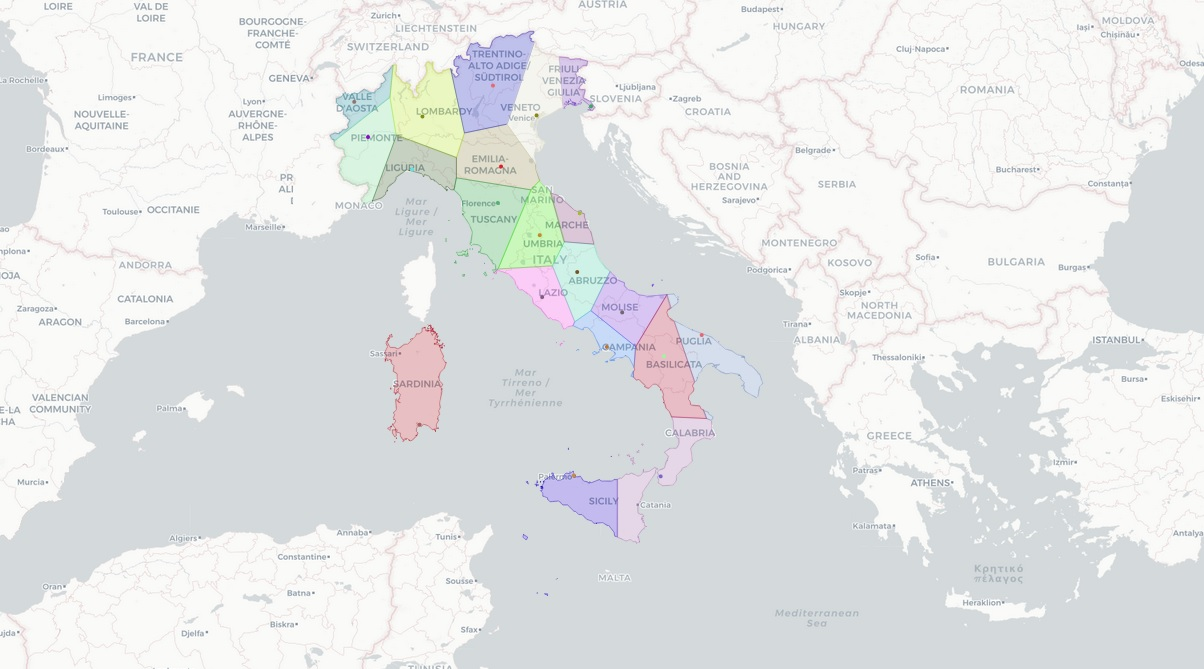

In [ ]:
# For the provinces
Voronoi_Italy(province_cap).plot()

As before the result into an image:
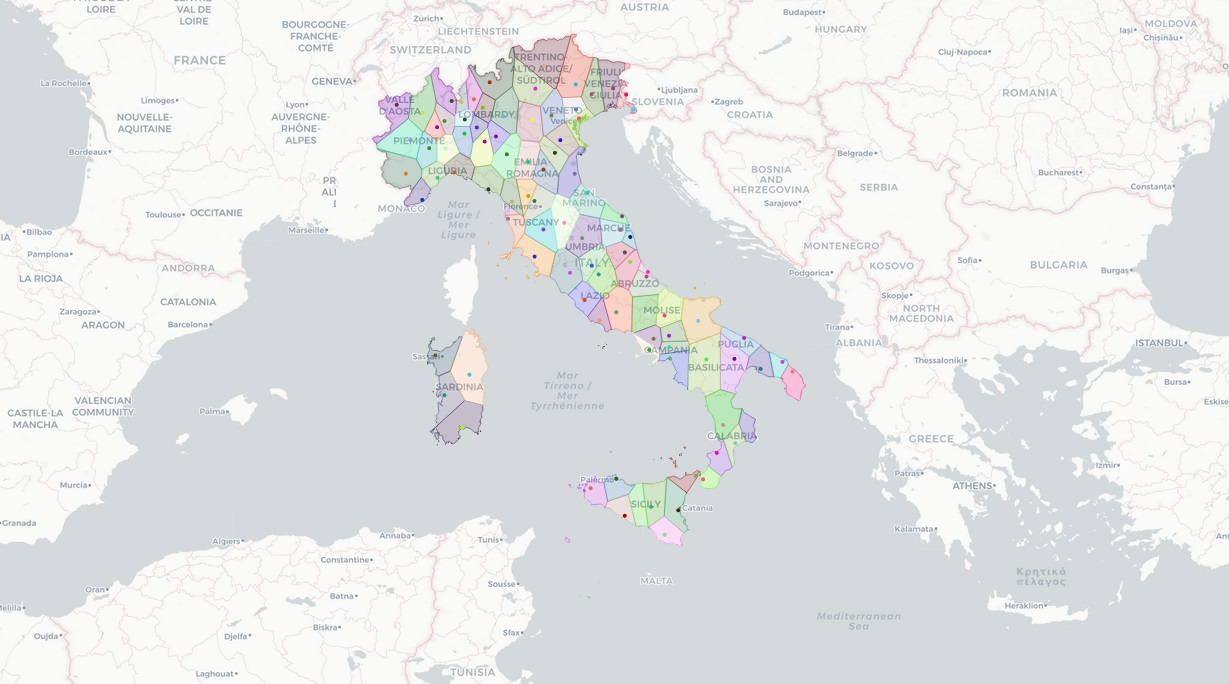